In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklvq import GMLVQ
from timeit import timeit


matplotlib.rc("xtick", labelsize="small")
matplotlib.rc("ytick", labelsize="small")

data = pd.read_csv("fourcl.csv").to_numpy()
labels = pd.read_csv("fourcl_labels.csv").to_numpy().squeeze()
# data = np.genfromtxt('fourcl.csv', delimiter=',')
# labels = np.genfromtxt('fourcl_labels.csv', delimiter=',')
#feature_names = [name[:-5] for name in iris.feature_names]

In [3]:
print(data.shape)
print(labels.shape)

(3999, 10)
(3999,)




# Generalized Matrix LVQ (GMLVQ)

In [4]:
# numpy array labels 
# labelpd = pd.read_csv('fourcl_labels.csv',header=None).to_numpy()

In [5]:
# labelpd = labelpd.squeeze()

In [6]:
# np.shape(labelpd)

In [7]:
# np.shape(data)

In [8]:
# labels = labelpd

## Fitting the Model
Scale the data and create a GLVQ object with, e.g., custom distance function, activation
function and solver. See the API reference under documentation for defaults and other
possible parameters.



In [9]:
# Sklearn's standardscaler to perform z-transform
scaler = StandardScaler()

# Compute (fit) and apply (transform) z-transform
data = scaler.fit_transform(data)

# The creation of the model object used to fit the data to.
model = GMLVQ(
    distance_type="adaptive-squared-euclidean",
    activation_type="sigmoid",
    activation_params={"beta": 2},
    solver_type="sgd",
    solver_params={"max_runs": 20,"batch_size":1,"step_size": np.array([0.1, 0.05])},
    random_state=1428,
)

In [10]:
data.shape

(3999, 10)

The next step is to fit the GMLVQ object to the data and use the predict method to make the
predictions. Note that this example only works on the training data and therefor does not say
anything about the generalizability of the fitted model.



In [11]:
# Train the model using the scaled data and true labels
model.fit(data, labels)

# Predict the labels using the trained model
# predicting on the same trianing data?
predicted_labels = model.predict(data)
print(len(data))
# To get a sense of the training performance we could print the classification report.
print(classification_report(labels, predicted_labels))

3999
              precision    recall  f1-score   support

          A1       0.71      0.70      0.70       999
          A2       0.74      0.66      0.70      1000
          B1       0.71      0.72      0.71      1000
          B2       0.68      0.75      0.71      1000

    accuracy                           0.71      3999
   macro avg       0.71      0.71      0.71      3999
weighted avg       0.71      0.71      0.71      3999



In [12]:
feature_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']#, 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','ab','ac','ad','ae','af','ag','ah','ai','aj','ak']


## Extracting the Relevance Matrix
In addition to the prototypes (see GLVQ example), GMLVQ learns a
matrix `lambda_` which can tell us something about which features are most relevant for the
classification.



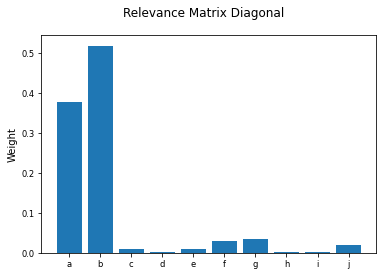

In [13]:
# The relevance matrix is available after fitting the model.
relevance_matrix = model.lambda_

# Plot the diagonal of the relevance matrix
fig, ax = plt.subplots()
fig.suptitle("Relevance Matrix Diagonal")
ax.bar(feature_names, np.diagonal(relevance_matrix))
ax.set_ylabel("Weight")
ax.grid(False)

## Transforming the data
In addition to making predictions GMLVQ can be used to transform the data using the
eigenvectors of the relevance matrix.



4
['A1' 'A2' 'B1' 'B2']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


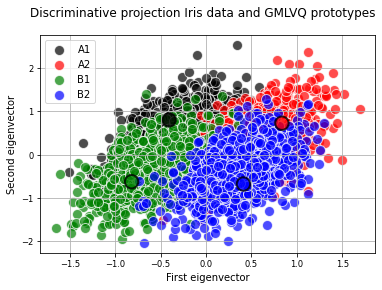

In [14]:
# Transform the data (scaled by square root of eigenvalues "scale = True")
# data is the remaining datapoints.
transformed_data = model.transform(data, scale=True)

x_d = transformed_data[:, 0]
y_d = transformed_data[:, 1]

# Transform the model, i.e., the prototypes (scaled by square root of eigenvalues "scale = True")
# prototypes are the 4 dots
transformed_model = model.transform(model.prototypes_, scale=True)
print(len(model.prototypes_))
x_m = transformed_model[:, 0]
y_m = transformed_model[:, 1]
#prototypes = ['PD','AD','HC']
# Plot
fig, ax = plt.subplots()
fig.suptitle("Discriminative projection Iris data and GMLVQ prototypes")
colors = ["black", "red", "green","blue"]
for i, cls in enumerate(model.classes_):
    ii = cls == labels
    ax.scatter(
        x_d[ii],
        y_d[ii],
        c=colors[i],
        s=100,
        alpha=0.7,
        edgecolors="white",
        label=model.classes_[model.prototypes_labels_[i]],
    )
ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
ax.set_xlabel("First eigenvector")
ax.set_ylabel("Second eigenvector")
ax.legend()
ax.grid(True)
print(model.classes_)
#plt.savefig('destination_path1.eps', format='eps')
print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

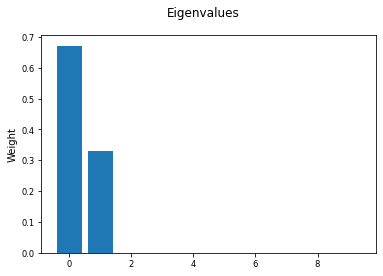

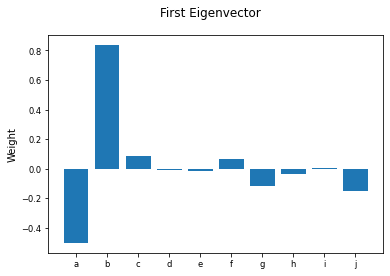

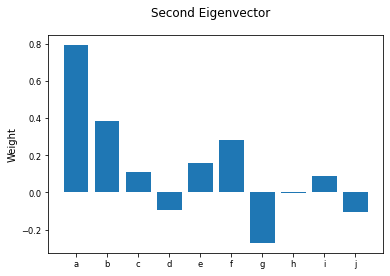

In [15]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
fig, ax = plt.subplots()
fig.suptitle("Eigenvalues")
ax.bar(range(0, len(model.eigenvalues_)), model.eigenvalues_)
ax.set_ylabel("Weight")
ax.grid(False)

# Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
fig, ax = plt.subplots()
fig.suptitle("First Eigenvector")
ax.bar(feature_names, model.omega_hat_[0, :])
ax.set_ylabel("Weight")
ax.grid(False)

fig, ax = plt.subplots()
fig.suptitle("Second Eigenvector")
ax.bar(feature_names, model.omega_hat_[1, :])
ax.set_ylabel("Weight")
ax.grid(False)

In [16]:
# original labels
labels

array(['A1', 'A1', 'A1', ..., 'B2', 'B2', 'B2'], dtype=object)

In [17]:
# changing labels to Class A and B    
labelssubclass = labels
labelssubclass = np.where(labels == 'A1','A',labelssubclass) 
labelssubclass = np.where(labels == 'A2','A',labelssubclass) 
labelssubclass = np.where(labels == 'B1','B',labelssubclass) 
labelssubclass = np.where(labels == 'B2','B',labelssubclass) 


In [18]:
# changed labels
labelssubclass

array(['A', 'A', 'A', ..., 'B', 'B', 'B'], dtype=object)

In [19]:
data.shape

(3999, 10)

In [20]:
# Train the model using the scaled data and true labels
model.fit(data, labelssubclass)

# Predict the labels using the trained model
predicted_labels = model.predict(data)
# To get a sense of the training performance we could print the classification report.
print(classification_report(labelssubclass, predicted_labels))

              precision    recall  f1-score   support

           A       0.78      0.74      0.76      1999
           B       0.75      0.79      0.77      2000

    accuracy                           0.76      3999
   macro avg       0.76      0.76      0.76      3999
weighted avg       0.76      0.76      0.76      3999



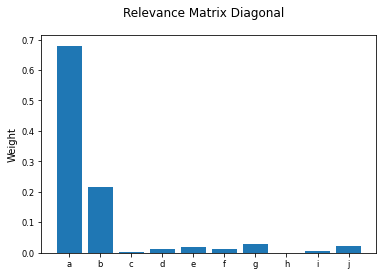

In [21]:
# The relevance matrix is available after fitting the model.
# for Class A and B
relevance_matrix1 = model.lambda_

# Plot the diagonal of the relevance matrix
fig, ax = plt.subplots()
fig.suptitle("Relevance Matrix Diagonal")
ax.bar(feature_names, np.diagonal(relevance_matrix1))
ax.set_ylabel("Weight")
ax.grid(False)

2
['A' 'B']
A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) 


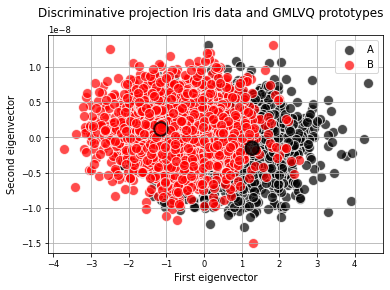

In [22]:
# retraining the model for 2 class A and B
transformed_data = model.transform(data, scale=True)

x_d = transformed_data[:, 0]
y_d = transformed_data[:, 1]

transformed_model = model.transform(model.prototypes_, scale=True)
print(len(model.prototypes_))
x_m = transformed_model[:, 0]
y_m = transformed_model[:, 1]

fig, ax = plt.subplots()
fig.suptitle("Discriminative projection Iris data and GMLVQ prototypes")
colors = ["black", "red"]#, "green","blue"]
for i, cls in enumerate(model.classes_):
    ii = cls == labelssubclass
    ax.scatter(
        x_d[ii],
        y_d[ii],
        c=colors[i],
        s=100,
        alpha=0.7,
        edgecolors="white",
        label=model.classes_[model.prototypes_labels_[i]],
    )
ax.scatter(x_m, y_m, c=colors, s=180, alpha=0.8, edgecolors="black", linewidth=2.0)
ax.set_xlabel("First eigenvector")
ax.set_ylabel("Second eigenvector")
ax.legend()
ax.grid(True)
print(model.classes_)
#plt.savefig('destination_path23.eps', format='eps')
print('A1: Black, A2: Red, B1: Green, B2: Blue, Centers A and B, and diseases 1 and 2.) ')

In [23]:
#print(np.where((labels == 'A1') & (labels == 'A2')))# and np.where(labels == 'A2')              

The transformed data and prototypes can be used to visualize the problem in a lower dimension,
which is also the space the model would compute the distance. The axis are the directions which
are the most discriminating directions (combinations of features). Hence, inspecting the
eigenvalues and eigenvectors (axis) themselves can be interesting.



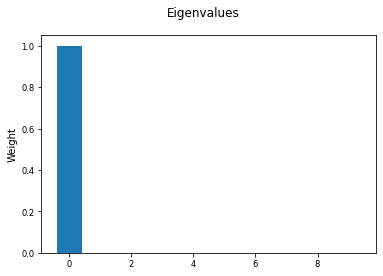

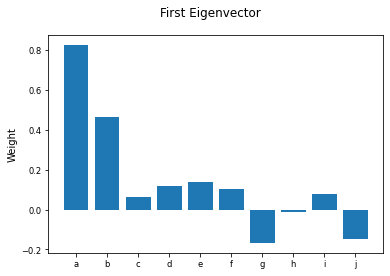

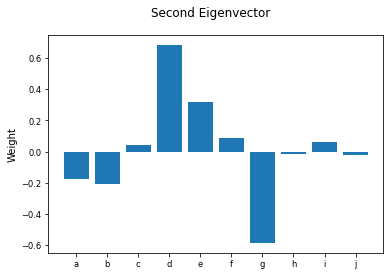

In [24]:
# Plot the eigenvalues of the eigenvectors of the relevance matrix.
fig, ax = plt.subplots()
fig.suptitle("Eigenvalues")
ax.bar(range(0, len(model.eigenvalues_)), model.eigenvalues_)
ax.set_ylabel("Weight")
ax.grid(False)

# Plot the first two eigenvectors of the relevance matrix, which  is called `omega_hat`.
fig, ax = plt.subplots()
fig.suptitle("First Eigenvector")
ax.bar(feature_names, model.omega_hat_[0, :])
ax.set_ylabel("Weight")
ax.grid(False)

fig, ax = plt.subplots()
fig.suptitle("Second Eigenvector")
ax.bar(feature_names, model.omega_hat_[1, :])
ax.set_ylabel("Weight")
ax.grid(False)

In [25]:
model.eigenvalues_
# the eigenvectors are column vectors.


array([ 1.00000000e+00,  1.46304569e-17,  1.13417404e-17,  4.29386794e-18,
        1.18739230e-18,  3.71591264e-19, -7.70430980e-20, -6.43764722e-18,
       -7.48890832e-18, -1.39617461e-16])

## I have changed the following block

In [26]:
# verified and checked the dimensions
square = np.sqrt(np.absolute(model.eigenvalues_))
# omega transpose is the column matrix with eigen values and eigen vectors multipled. 
omegatranspose = np.zeros((10,10))
for i in range(len(square)):
    #print(square[i])
    #print(model.omega_hat_[i,:])
    omegatranspose[i,:] = (square[i]*model.omega_hat_[i,:])

# replacing the nan values with 0, warning due to sqrt of negative eigenvalues -> this is due to rounding errors... either set all eigenvalues that are negative to 0 or use absolute?
omegatranspose = np.nan_to_num(omegatranspose) 

assert np.allclose(model.lambda_, omegatranspose.T.dot(omegatranspose))

## Into this (this is actually something that should be better in the sklvq package, so my bad)

In [27]:
# Eigenvalues cannot be negative (in our case) and if you check the values you will see that all the negative values are very small. These are caused by finite precision errors etc. so we can just put them to zero.
eigenvalues = model.eigenvalues_
eigenvalues[eigenvalues < 0] = 0

# The release has some inconsistency in the naming of things (I am working on the improvement) omega_hat actually contains the eigenvectors. 
eigenvectors = model.omega_hat_

# And the real omega_hat can then be computed as follows
omega_hat = np.sqrt(eigenvalues[:, None]) * eigenvectors

# We can check if it is all correct by recomputing lambda using the omega_hat and asserting the values are equal (or at least very close to equal) to lambda_ stored in the model.
assert np.allclose(model.lambda_, omega_hat.T.dot(omega_hat))

## This is how one could compute the "correction matrix"

In [28]:
# [I - sum(v_k v_k^T)]
n_samples, n_dims = data.shape

# Check the leading (non-zero eigenvalue) eigenvectors -> very small numbers are considered zero. Only one eigenvectors survives. 
#print(f"The eigenvalues are:\n{eigenvalues}\n")

# The leading eigenvector is the first (index 0) one. 
leading_eigvec = np.atleast_2d(eigenvectors[0, :])
correction_matrix = np.identity(n_dims) - leading_eigvec.T.dot(leading_eigvec)
np.savetxt('correctionmatrixRick', correction_matrix, fmt='%1.4e') 


## Now we have the correction matrix the procedure (to be implemented in the sklvq package) is this:

In [29]:
# This is what will happen in the next training procedure but we can check (as in the writeups)

# As an example take omega (found during training)
omega = model.omega_
# The correction procedure after eacht update of omega would be (in the code it would not be called omega_hat but just omega):
%time omega_hat = omega.T.dot(correction_matrix)
np.savetxt('omega_hatRick', omega_hat, fmt='%1.4e') 
omega_hat = omega_hat/np.sqrt(np.sum(np.square(omega_hat)))
np.savetxt('Normalisedomega_hatRick', omega_hat, fmt='%1.4e') 


CPU times: user 145 µs, sys: 0 ns, total: 145 µs
Wall time: 117 µs


### Nehas Code

In [30]:
eigenvalues = model.eigenvalues_
eigenvalues[eigenvalues<0] = 0
eigenvaluessqureroot = np.sqrt(eigenvalues)

omega_hat1 = np.zeros((10,10))
omega_hat1 = (eigenvaluessqureroot[:,None]*model.omega_hat_)

# As an example take omega (found during training)
# row vector
omega1 = model.omega_

N=10
K=1
I = np.identity(N)
outerproduct = np.zeros((N,N))        
for i in range(K):
    # column times rows
    outerproduct = outerproduct + np.outer(model.omega_hat_[i,:].T,model.omega_hat_[i,:])

np.savetxt('outerproductNeha', outerproduct, fmt='%1.4e') 

correctionmatrix = I-outerproduct
np.savetxt('correctionmatrixNeha', correctionmatrix, fmt='%1.4e') 

%time omega_hat_T1 = np.matmul(omega1.T,correctionmatrix)
np.savetxt('omega_hatNeha', omega_hat_T1, fmt='%1.4e') 

# normalizing omega_new_hat
omega_hat_T1 = omega_hat_T1 / np.sqrt(np.sum(np.square(omega_hat_T1)))

np.savetxt('normalizedomega_hatNeha', omega_hat_T1, fmt='%1.4e')
# assigning omega_hat as omega for further training steps
omega1 = omega_hat_T1


CPU times: user 0 ns, sys: 61 µs, total: 61 µs
Wall time: 71.5 µs


In [31]:
# We get different answers.
# omega_hat_T1 is normalized
assert np.allclose(omega_hat_T1, omega_hat)

In [32]:
# checking normalization.
print(np.sum(np.square(omega_hat_T1)))

0.9999999999999997


In the plots from the eigenvalues and eigenvector we see a similar effects as we could see from
just the diagonal of `lambda_`. The two leading (most relevant or discriminating) eigenvectors
mostly use the petal length and petal width in their calculation. The diagonal of the
relevance matrix can therefor be considered as a summary of the relevances of the features.



## References
_`[1]` Schneider, P., Biehl, M., & Hammer, B. (2009). "Adaptive Relevance Matrices in Learning
Vector Quantization" Neural Computation, 21(12), 3532–3561, 2009.

